In [1]:
import mdtraj as md
import dask_traj as dmd
import dask
import itertools as itt
import numpy as np
from dask.distributed import Client
from dask.array import allclose
#dask.config.set(scheduler='sync')

In [2]:
xtc = '5550217/new.xtc'
pdb = '5550217/new.pdb'
gro = '5550217/new.gro'
#xyz = '54.xyz'

In [3]:
client = Client()

In [4]:
client

Client Scheduler: tcp://127.0.0.1:46061 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.42 GB


In [5]:
%time dask_traj = dmd.load(xtc, top=gro, chunks=100)

CPU times: user 361 ms, sys: 74.1 ms, total: 435 ms
Wall time: 1.85 s


In [6]:
dask_traj

<mdtraj.Trajectory with 1251 frames, 22561 atoms, 6832 residues, and unitcells at 0x7f72b8f8b9b0>

In [7]:
#dask_traj = dask_traj + dask_traj

In [8]:
#dask_traj

In [9]:
%time mdtraj = md.load(xtc, top=gro)

CPU times: user 1.95 s, sys: 172 ms, total: 2.12 s
Wall time: 2.02 s


In [10]:
mdtraj

<mdtraj.Trajectory with 1251 frames, 22561 atoms, 6832 residues, and unitcells at 0x7f72eb567518>

In [11]:
#make some atom pairs
c = list(itt.combinations(range(500),2))
#This does not work anymore for mdtraj (Memory error, depending on the RAM size)
#, but should still work for dask_traj
#c = list(itt.combinations(range(3000),2))

In [12]:
len(c)

124750

In [13]:
%%time
data  = client.scatter(dask_traj)
fut = client.submit(dmd.compute_distances, data, atom_pairs=c, pure=False )
dmd_result = fut.result()
dmd_out = dmd_result.compute()

CPU times: user 1.13 s, sys: 675 ms, total: 1.8 s
Wall time: 5.82 s


In [14]:
dmd_result

dask.array<concatenate, shape=(1251, 124750), dtype=float32, chunksize=(100, 124750)>

In [15]:
#%%time 
#dmd_result = dmd.compute_distances(dask_traj, atom_pairs=c)

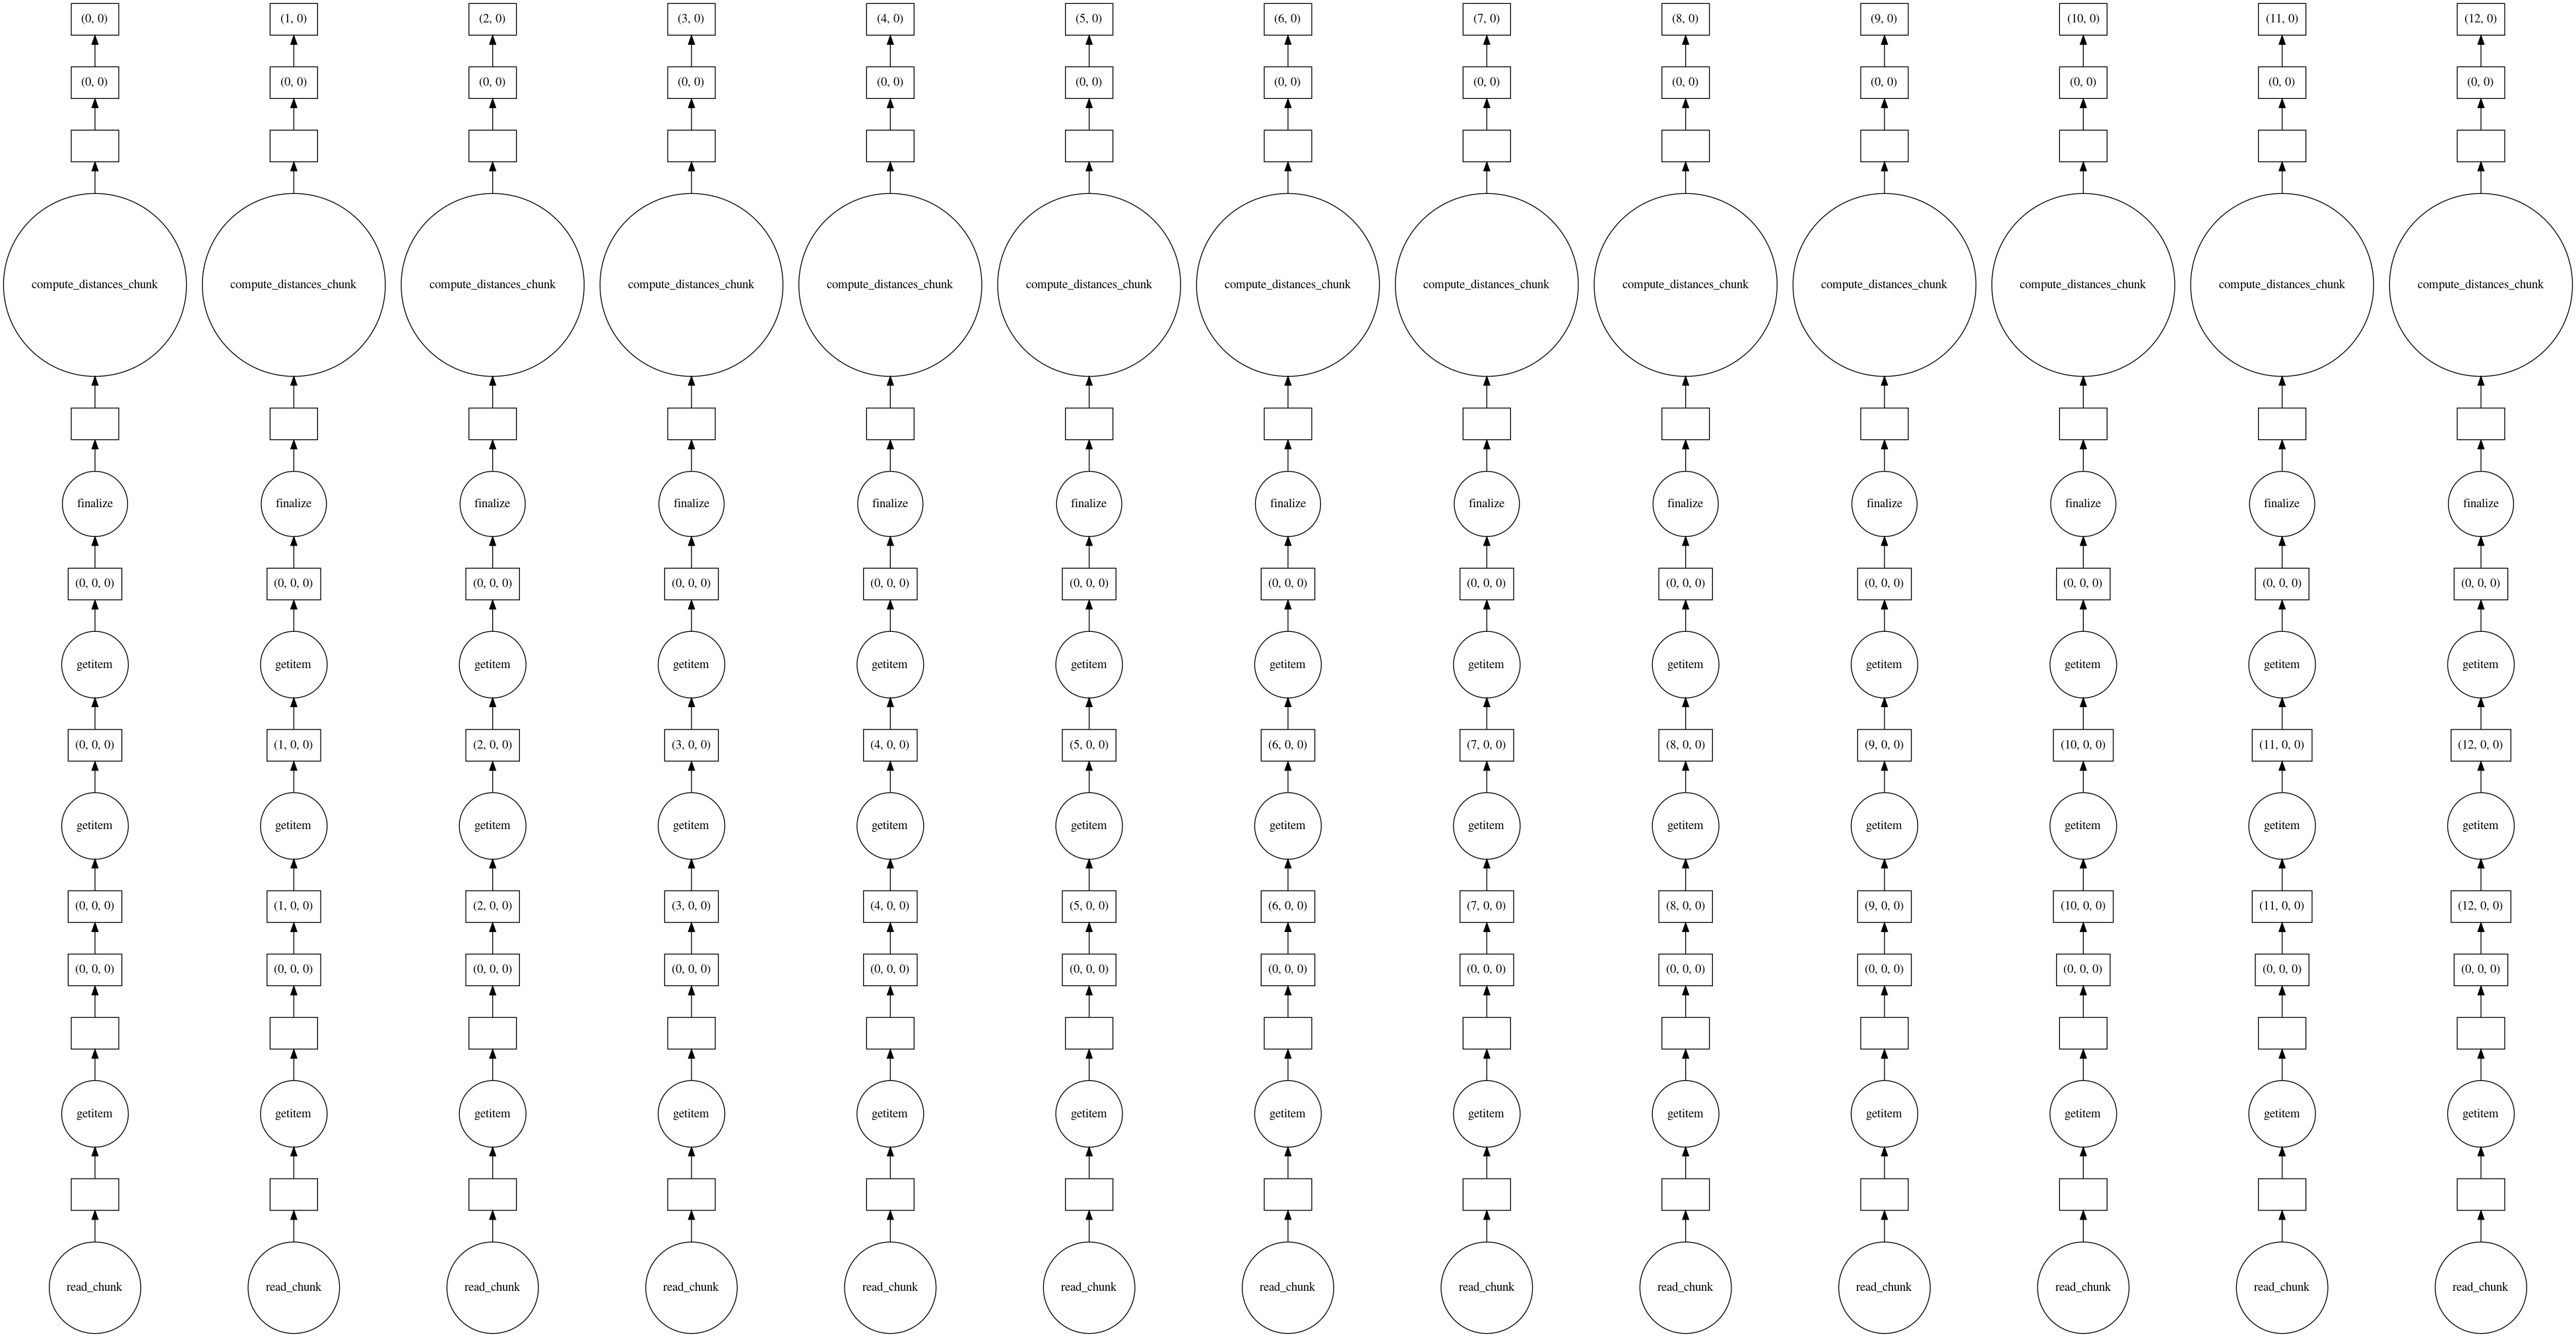

In [16]:
dmd_result.visualize()

In [17]:
dmd_out

array([[0.1014791 , 0.10119769, 0.10115819, ..., 0.20895208, 0.3013205 ,
        0.10936645],
       [0.10096513, 0.10082649, 0.10140543, ..., 0.2117476 , 0.3043042 ,
        0.10861864],
       [0.10097025, 0.10124216, 0.10097533, ..., 0.21021414, 0.30004996,
        0.10856345],
       ...,
       [0.10058825, 0.1010496 , 0.10097037, ..., 0.21064195, 0.3037204 ,
        0.10966318],
       [0.10127181, 0.10077702, 0.10146917, ..., 0.21887217, 0.30625457,
        0.10951238],
       [0.1007573 , 0.10143467, 0.10112376, ..., 0.21415856, 0.30125386,
        0.1086186 ]], dtype=float32)

In [18]:
%%time
md_result = md.compute_distances(mdtraj, atom_pairs=c)

CPU times: user 11.7 s, sys: 133 ms, total: 11.8 s
Wall time: 11.7 s


In [19]:
md_result

array([[0.1014791 , 0.10119769, 0.10115819, ..., 0.20895208, 0.3013205 ,
        0.10936645],
       [0.10096513, 0.10082649, 0.10140543, ..., 0.2117476 , 0.3043042 ,
        0.10861864],
       [0.10097025, 0.10124216, 0.10097533, ..., 0.21021414, 0.30004996,
        0.10856345],
       ...,
       [0.10058825, 0.1010496 , 0.10097037, ..., 0.21064195, 0.3037204 ,
        0.10966318],
       [0.10127181, 0.10077702, 0.10146917, ..., 0.21887217, 0.30625457,
        0.10951238],
       [0.1007573 , 0.10143467, 0.10112376, ..., 0.21415856, 0.30125386,
        0.1086186 ]], dtype=float32)

In [24]:
#If arrays are the same size the initi
(md_result.shape == dmd_result.shape and (md_result == dmd_out).all())

True